<a href="https://colab.research.google.com/github/adarsh-nl/RLHF-based-ImgaeCaptionGeneration/blob/main/RLHF_weights_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import string
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.applications.xception import Xception, preprocess_input
from pickle import dump, load
import random
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.losses import KLDivergence


"""
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args())
img_path = args['image']
"""

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        #feature = model.predict(image) reference: https://stackoverflow.com/questions/61923379/simple-keras-network-in-gradienttape-lookuperror-no-gradient-defined-for-opera
        feature = model(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def sample_pred(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = preds.flatten() # flatten the array to make it 1D
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        preds = model.predict([photo, sequence], verbose=0)
        preds = preds.reshape((preds.shape[1],))
        next_index = sample_pred(preds, temperature=0.5) #adjust the temperature parameter to control the randomness of predictions
        word = word_for_id(next_index, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [75]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/drive/MyDrive/CV Project - Image caption generator/Models/tokenizer.p","rb"))
model = load_model('/content/drive/MyDrive/CV Project - Image caption generator/Models/model_11.h5')
#model = load_model('/content/models/model_rl.h5')
xception_model = Xception(include_top=False, pooling="avg")
dataset_images = "/content/drive/MyDrive/CV Project - Image caption generator/archive (1)/Images"

In [76]:
q_table = {}
for i in range(max_length):
    q_table[i] = {}
    for word, index in tokenizer.word_index.items():
        q_table[i][index] = 0.5

In [77]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

loss_fn = categorical_crossentropy
optimizer = Adam(learning_rate=0.001)


In [78]:
def load_document(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

DEBUG = False

def debug(str):
  if DEBUG:
    print(str)

In [79]:
def create_image_caption_dictionary(filename):
  captions = load_document(filename)
  splited_captions = captions.split('\n')
  debug(captions.split('\n'))
  descriptions = {}
  for i in splited_captions[1:-1]:
    i = str(i)
    debug(i)
    image, caption = i.split(',',1)
    if image not in descriptions:
      descriptions[image] = [caption]
    else:
      descriptions[image].append(caption)
  return descriptions

In [80]:
descriptions = create_image_caption_dictionary('/content/drive/MyDrive/CV Project - Image caption generator/archive (1)/captions.txt')

def printDictionary(dictionary, prnt = False):
  if prnt:
    keys = list(dictionary.keys())
    print(keys)
    for i in keys:
      print("Image: {}, captions: {}".format(i, descriptions.get(i)))
  pass

printDictionary(descriptions, prnt = False) #set prnt to true to visulize the pre processed text data for the image captions.

In [81]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

cln_descriptions = cleaning_text(descriptions)
#print(cln_descriptions)

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin'], '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other'], '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'little girl is sitting in front of large painted rainbow', 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'there is girl with pigtails sitting in front of rainbow painting', 'young girl with pigtails paintin

In [82]:
def get_true_caption(image_path, caption_dict):
    # Extract the image filename from the path
    image_filename = os.path.basename(image_path)
    
    # Look up the true caption for this image in the dictionary
    true_captions = caption_dict.get(image_filename)
    
    # Return one of the true captions at random
    return np.random.choice(list(true_captions))

In [83]:
# Initialize RL model parameters
alpha = 0.1 # Learning rate
epsilon = 0.1 # Exploration rate
gamma = 0.9 # Discount factor
q_table = np.random.rand(max_length, len(tokenizer.word_index) + 1)
RL_learning_loop = 0

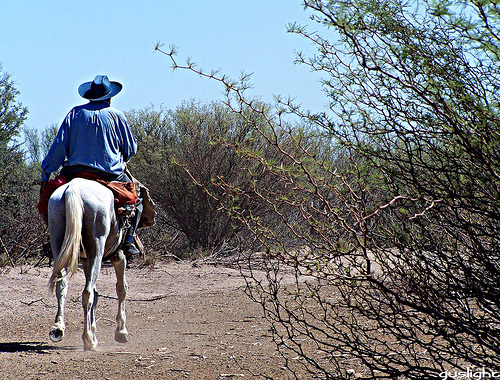

Generated caption: start man in black shirt and black helmet and an orange shirt is riding horse on the grass end
Loss:  tf.Tensor(8.562738361446609, shape=(), dtype=float64)
Gradient [None, None, None, None, None, None, None, None, None, None, None, None, None]
**************************


ValueError: ignored

In [84]:
# Define loss function and optimizer
loss_fn = categorical_crossentropy
optimizer = Adam(learning_rate=0.001)

# Update model parameters using RL algorithm
with tf.GradientTape() as tape:
    # code for forward pass and loss computation
  for img in os.listdir(dataset_images): # Number of RL iterations
      RL_learning_loop += 1
      if RL_learning_loop < 10:
        image_path = dataset_images + "/" + img
        image = Image.open(image_path)
        #image = image.resize(300,300)
        image.show()
        photo = extract_features(image_path, xception_model)
        in_text = 'start'
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            #preds = model.predict([photo,sequence], verbose=0)
            preds = model([photo,sequence])
            next_index = sample_pred(preds, temperature=0.5) # introduce randomness with temperature=0.5
            next_word = word_for_id(next_index, tokenizer)
            if next_word is None:
                break
            in_text += ' ' + next_word
            if next_word == 'end':
                break

        print("Generated caption:", in_text)
        
        # Compute loss between predicted and ground-truth caption
        true_caption = get_true_caption(image_path, cln_descriptions) # implement function to get ground-truth caption
        true_sequence = tokenizer.texts_to_sequences([true_caption])[0]
        true_sequence = pad_sequences([true_sequence], maxlen=max_length)
        y_true = np.zeros((1, max_length, len(tokenizer.word_index) + 1))
        for i, word_index in enumerate(true_sequence[0]):
            y_true[0, i, word_index] = 1
        y_pred = np.zeros((1, max_length, len(tokenizer.word_index) + 1))
        for i, word_index in enumerate(sequence[0]):
            y_pred[0, i, word_index] = 1
        loss = loss_fn(y_true, y_pred)
        loss = tf.reduce_mean(loss)

        print("Loss: ",loss)

        trainable_vars = []
        for var in model.trainable_variables:
            if 'embedding' not in var.name and 'conv2d' not in var.name:
                trainable_vars.append(var)
                
        grads = tape.gradient(loss, trainable_vars)
        print("Gradient",grads)
        print("**************************")
        optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update model weights based on loss
        #grads = tape.gradient(loss, model.trainable_weights)
        #print("Gradient",grads)
        #print("**************************")
        #print(model.trainable_weights)
        #optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        feedback = float(input("Rate the quality of the caption (0-1): "))
        for i in range(len(in_text.split())):
            word = in_text.split()[i]
            action = tokenizer.word_index[word]
            if i == len(in_text.split())-1:
                next_max_q_value = 0
            else:
                next_word = in_text.split()[i+1]
                next_action = tokenizer.word_index[next_word]
                next_max_q_value = np.max(q_table[i+1][next_action])
            q_table[i][action] += alpha * (feedback + gamma * next_max_q_value - q_table[i][action])

        # Save updated model and Q-table
        model.save('models/model_rl.h5')
        dump(q_table, open("q_table.p", "wb"))


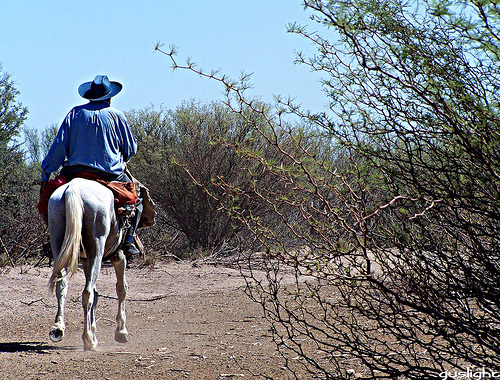

Generated caption: start man wearing grey and blue top riding horse end
Loss:  tf.Tensor(6.0442852646807825, shape=(), dtype=float64)
Gradient [None, None, None, None, None, None, None, None, None, None, None, None, None]
**************************


ValueError: ignored

In [88]:
from tensorflow.keras.losses import KLDivergence

# Define loss function and optimizer
loss_fn = KLDivergence()

optimizer = Adam(learning_rate=0.1)

# Update model parameters using RL algorithm
for img in os.listdir(dataset_images): # Number of RL iterations
    RL_learning_loop += 1
    if RL_learning_loop < 10:
        image_path = dataset_images + "/" + img
        image = Image.open(image_path)
        #image = image.resize(300,300)
        image.show()
        photo = extract_features(image_path, xception_model)
        in_text = 'start'
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            #preds = model.predict([photo,sequence], verbose=0)
            preds = model([photo,sequence])
            next_index = sample_pred(preds, temperature=0.5) # introduce randomness with temperature=0.5
            next_word = word_for_id(next_index, tokenizer)
            if next_word is None:
                break
            in_text += ' ' + next_word
            if next_word == 'end':
                break

        print("Generated caption:", in_text)

        # Compute loss between predicted and ground-truth caption
        true_caption = get_true_caption(image_path, cln_descriptions) # implement function to get ground-truth caption
        true_sequence = tokenizer.texts_to_sequences([true_caption])[0]
        true_sequence = pad_sequences([true_sequence], maxlen=max_length)
        y_true = np.zeros((1, max_length, len(tokenizer.word_index) + 1))
        for i, word_index in enumerate(true_sequence[0]):
            y_true[0, i, word_index] = 1
        y_pred = np.zeros((1, max_length, len(tokenizer.word_index) + 1))
        for i, word_index in enumerate(sequence[0]):
            y_pred[0, i, word_index] = 1
        loss = loss_fn(y_true, y_pred)
        loss = tf.reduce_mean(loss)

        print("Loss: ",loss)

        with tf.GradientTape() as tape:
            trainable_vars = []
            for var in model.trainable_variables:
                if 'embedding' not in var.name and 'conv2d' not in var.name:
                    trainable_vars.append(var)

            grads = tape.gradient(loss, trainable_vars)
            print("Gradient",grads)
            print("**************************")
            optimizer.apply_gradients(zip(grads, trainable_vars))

        # Update model weights based on loss
        #grads = tape.gradient(loss, model.trainable_weights)
        #print("Gradient",grads)
        #print("**************************")
        #print(model.trainable_weights)
        #optimizer.apply_gradients(zip(grads, model.trainable_weights))

        feedback = float(input("Rate the quality of the caption (0-1): "))
        for i in range(len(in_text.split())):
            word = in_text.split()[i]
            action = tokenizer.word_index[word]
            if i == len(in_text.split())-1:
                next_max_q_value = 0
            else:
                next_word = in_text.split()[i+1]
                next_action = tokenizer.word_index[next_word]
                next_max_q_value = np.max(q_table[i+1][next_action])
            q_table[i][action] += alpha * (feedback + gamma * next_max_q_value - q_table[i][action])

        # Save updated model and Q-table
        model.save('models/model_rl.h5')
        dump(q_table, open("q_table.p", "wb"))